In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/tmp/ipykernel_3750814/3826238445.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:1')

In [91]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # [1, 64, 96]
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ELU(),
            # [32, 32, 48]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ELU(),
            # [64, 16, 24]
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ELU(),
            # [64, 8, 12]
            nn.Flatten(),
            nn.Linear(64 * 8 * 12, 128),
            nn.ELU()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128, 64),
            )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.Sigmoid()
            )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, 64 * 8 * 12),
            nn.ELU(),
            nn.Unflatten(1, (64, 8, 12)),
            # [64, 8, 12]
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ELU(),
            # [64, 16, 24]
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ELU(),
            # [32, 32, 48]
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def encode(self, x):
        h = self.encoder(x)
        # print(h.shape)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
    
model = VAE().to(device)
input = torch.zeros((1, 1, 64, 96)).to(device)
z, mu, logvar = model(input)
print(z.shape)

torch.Size([1, 1, 64, 96])


In [93]:
import cv2
import numpy as np

data = np.load('./all_img_data.npy')

class img_dataset(Dataset):
    def __init__(self, img_data):
        self.len = len(img_data)
        self.data = torch.from_numpy(img_data).to(device)
        
    def __getitem__(self, index):
        return self.data[index][0], self.data[index][1]

    def __len__(self):
        return self.len
    
dataset = img_dataset(data)
BATCH_SIZE = 128
train_set_iter = DataLoader(dataset=dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True)


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.71 GiB. GPU 1 has a total capacity of 23.68 GiB of which 1.43 GiB is free. Including non-PyTorch memory, this process has 21.61 GiB memory in use. Of the allocated memory 17.69 GiB is allocated by PyTorch, and 3.61 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [27]:
testdata = np.load('./test_img_data.npy')
dataset = img_dataset(data)
BATCH_SIZE = 128
test_set_iter = DataLoader(dataset=dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True)

In [57]:
def loss_fn(recon_x, x, mu, logvar):
    # BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    BCE = nn.functional.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [58]:
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
for epoch in range(epochs):
    
    for idx, (img, images) in enumerate(train_set_iter):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, img, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.10f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.item()/BATCH_SIZE, bce.item()/BATCH_SIZE, kld.item()/BATCH_SIZE)
        print(to_print)

Epoch[1/10] Loss: 1281.1187744141 1281.117 0.002
Epoch[1/10] Loss: 1265.3465576172 1265.345 0.002
Epoch[1/10] Loss: 1227.7976074219 1227.796 0.002
Epoch[1/10] Loss: 1115.3636474609 1115.361 0.003
Epoch[1/10] Loss: 946.3580932617 946.355 0.004
Epoch[1/10] Loss: 687.5343017578 687.530 0.004
Epoch[1/10] Loss: 443.5833129883 443.579 0.004
Epoch[1/10] Loss: 283.8759765625 283.872 0.004
Epoch[1/10] Loss: 177.8022766113 177.798 0.004
Epoch[1/10] Loss: 178.5192718506 178.515 0.004
Epoch[1/10] Loss: 149.6004486084 149.596 0.004
Epoch[1/10] Loss: 194.6868438721 194.683 0.004
Epoch[1/10] Loss: 162.9647369385 162.961 0.004
Epoch[1/10] Loss: 160.6020660400 160.598 0.004
Epoch[1/10] Loss: 166.8494720459 166.845 0.004
Epoch[1/10] Loss: 174.4444732666 174.440 0.004
Epoch[1/10] Loss: 162.4038238525 162.400 0.004
Epoch[1/10] Loss: 149.1789398193 149.175 0.004
Epoch[1/10] Loss: 154.1732940674 154.169 0.004
Epoch[1/10] Loss: 152.1634979248 152.159 0.004
Epoch[1/10] Loss: 168.2742614746 168.270 0.004
Epoch

In [59]:
def compare(xx, x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x, xx])

In [1]:
model = VAE().to(device)
model.load_state_dict(torch.load('./examples/rl_race/vae_model/vae_old.torch'))
model.eval()

NameError: name 'VAE' is not defined

torch.Size([1, 1, 64, 96])


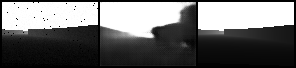

In [87]:
index = randint(1, 10000)
x, fixed_x = dataset[index][0].unsqueeze(0), dataset[index][1].unsqueeze(0)
print(fixed_x.shape)
compare_x = compare(x, fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [45]:
torch.save(model.state_dict(), 'vae.torch')

: 

In [14]:
torch.save(model.fc1.state_dict(), 'vae_fc1.torch')

: 